In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint
from itertools import chain

from IPython.display import Image, display

import parser as P
import automata as A


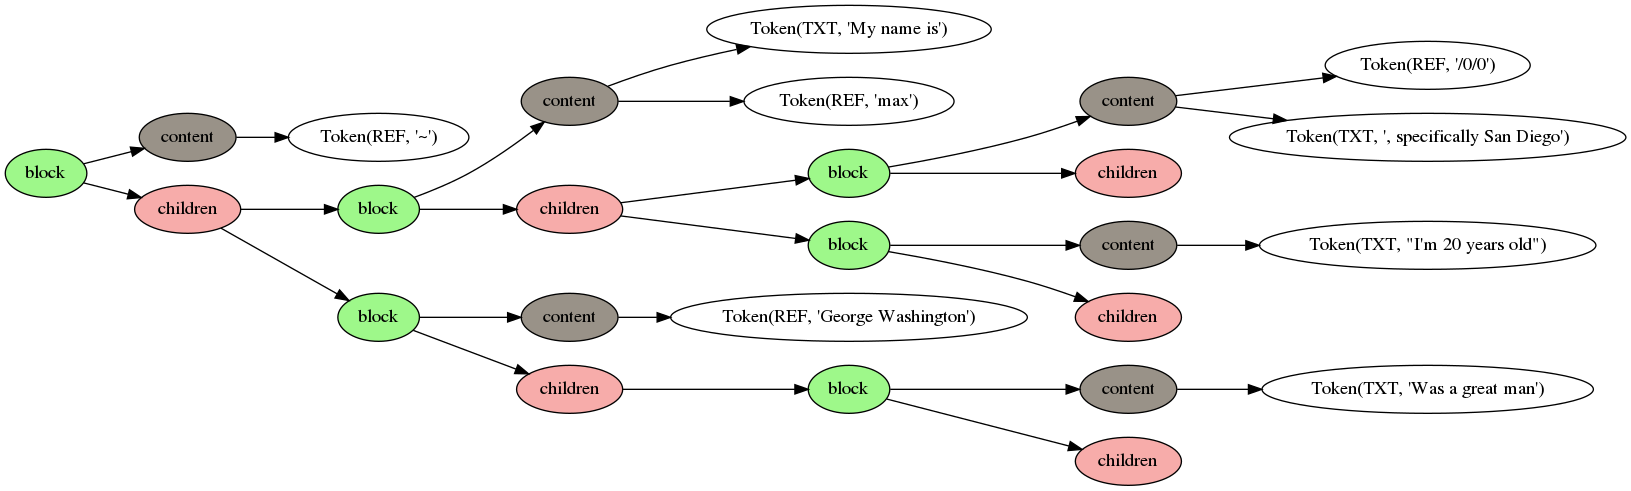

In [7]:
t = '''
- My name is [[max]]
  - [[/0/0]], specifically San Diego
  - I'm 20 years old
- [[George Washington]]
  - Was a great man
'''

NOTES_DATA = P.Block(content=[P.Token('REF', value='~')], children=P.parse_blocks(t))

NOTES_DATA.show()

{'/0/0', 'max', '~', 'George Washington'}


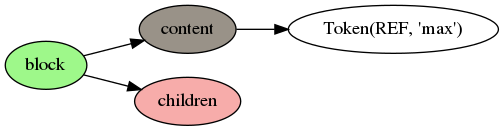

In [8]:
print(NOTES_DATA.get_refs(depth=10))
P.resolve_ref_block('max', NOTES_DATA).show()


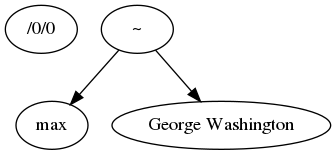

In [9]:

rules = A.Ruleset('test')

all_references = NOTES_DATA.get_refs(depth=100)
for x in all_references:
    rules.add_instance(x, x)
    block = P.resolve_ref_block(x, NOTES_DATA)
    for ref in block.get_refs(depth=1):
        if x != ref:
            rules.add_relation(x, ref)

rules.draw()

Image('./rules.png')


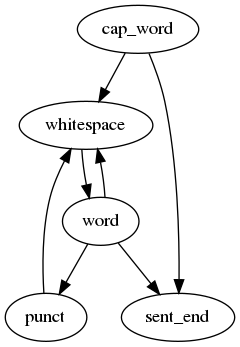

In [17]:
rules = A.Ruleset('sent')

rules.add_instance('cw', 'cap_word')
rules.add_instance('w', 'word')
rules.add_instance('ws', 'whitespace')
rules.add_instance('end', 'sent_end')
rules.add_instance('p', 'punct')

rules.add_relation('cw', 'ws')
rules.add_relation('cw', 'end')
rules.add_relation('w', 'ws')
rules.add_relation('ws', 'w')
rules.add_relation('w', 'end')
rules.add_relation('w', 'p')
rules.add_relation('p', 'ws')
rules.draw()
Image('./rules.png')


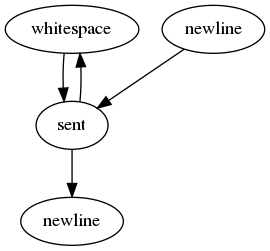

In [18]:
paras = A.Ruleset('para')

paras.add_instance('ws', 'whitespace')
paras.add_instance('sent', 'sent')
paras.add_instance('nl', 'newline')
paras.add_instance('nl2', 'newline')


paras.add_relation('nl', 'sent')
paras.add_relation('sent', 'ws')
paras.add_relation('ws', 'sent')
paras.add_relation('sent', 'nl2')
# paras.add_relation('nl', 'nl2')
paras.draw()
Image('./rules.png')

In [19]:
import re
from pprint import pprint
import process as Proc

reg_pats = {
    'word': re.compile(r'\b\w+\b'),
    'punct': re.compile(r'[.,\/#!$%\^&\*;:{}=\-_`~()]'),
    'caps': re.compile(r'[A-Z]'),
    'sent_end': re.compile(r'[.!?]'),
    'whitespace': re.compile(r'\s+'),
    'newline': re.compile(r'\n')
}

cap_words2 = A.Spec('cap_word')
cap_words2.add_req(lambda x, _: x.type == 'word')
cap_words2.add_req(lambda x, ctx: ctx.starts_at(
    x.match.start).contains_type('caps'))


text_path = './sherlock.txt'
text = open(text_path).read()


tokens = Proc.first_pass_process(reg_pats, text)
print('# punct fount:', len(tokens.filter(lambda x: x.type == 'punct')))


x = Proc.process({
    'cap_word': cap_words2.match,
    'sent': lambda x: rules.find(x, 100, 'cw'),
    'para': lambda x: paras.find(x, 2, 'nl')
}, tokens)

pprint(x.filter(lambda x: x.type == 'para'))


# punct fount: 6954
Found 5442 cap_word(s) in 1.60s.
Found 100 sent(s) in 2.87s.
Found 2 para(s) in 0.72s.
[<para @ (5683, 5854): "
❓You are as thin as a lath and as brown as a nut.❓

I gave him a short sketch of my adventures, and had hardly concluded it
by the time that we reached our destination.

">,
 <para @ (6335, 6509): "
He was bemoaning himself this morning because he could not get someone
to go halves with him in some nice rooms which he had found, and which
were too much for his purse.❓

">]


# 